# Probando merging 

In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import StorageLevel, SparkConf
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import copy
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import StandardScaler, VectorAssembler, PCA
from pyspark.mllib.linalg import SparseVector, DenseVector, VectorUDT
from pyspark.ml.classification import LogisticRegression

%matplotlib inline

In [4]:
#Leemos el dataframe
df = spark.read.parquet('hdd_dataset_new.parquet')

#Una de las primeras cosas que necesitamos hacer es convertir los . en _ ya que en pyspark no los reconoce correctamente
new_cols = [col.replace('.', '_') for col in df.columns]
df = df.toDF(*new_cols)
new_cols = [col.replace('-', '_') for col in df.columns]
df = df.toDF(*new_cols)

#Para los nodos reemplazamos los - por . y los abreviamos
udf_replace = udf(lambda x: x.replace('-','.'),returnType=StringType())
df = df.withColumn("node", udf_replace(df.node))

def abreviating_disk(a):
    return ".".join(a.split(".", 2)[:2])

abreviating_disk_UDF = udf(lambda z: abreviating_disk(z),StringType())

df = df.withColumn("node", abreviating_disk_UDF('node'))

#Leo las etiquetas
df_labels = spark.read.csv("labels_processed.csv", header=True)
df_labels.createOrReplaceTempView("data")
labelspd = spark.sql("SELECT CONCAT(node, '-',  disk)  FROM data").toPandas()

#Filtramos
node_disk = map(lambda x:x.encode("utf-8"),[item for sublist in labelspd.values.tolist() for item in sublist])
df = df.withColumn('nodedisk',concat(df.node,lit('-'), df.disk))
df = df.filter(df.nodedisk.isin(node_disk) == True)
df = df.drop('nodedisk')
print df.count()
df.cache()

100


DataFrame[node: string, disk: string, start_time: bigint, end_time: bigint, smart_Calibration_Retry_Count_raw_value: map<int,float>, smart_Command_Timeout_raw_value: map<int,float>, smart_Current_Pending_Sector_raw_value: map<int,float>, smart_End_to_End_Error_raw_value: map<int,float>, smart_G_Sense_Error_Rate_raw_value: map<int,float>, smart_Hardware_ECC_Recovered_raw_value: map<int,float>, smart_High_Fly_Writes_raw_value: map<int,float>, smart_Load_Cycle_Count_raw_value: map<int,float>, smart_Media_Wearout_Indicator_raw_value: map<int,float>, smart_Multi_Zone_Error_Rate_raw_value: map<int,float>, smart_Offline_Uncorrectable_raw_value: map<int,float>, smart_Power_Off_Retract_Count_raw_value: map<int,float>, smart_Power_Cycle_Count_raw_value: map<int,float>, smart_Power_On_Hours_raw_value: map<int,float>, smart_Program_Fail_Cnt_Total_raw_value: map<int,float>, smart_Raw_Read_Error_Rate_raw_value: map<int,float>, smart_Reallocated_Event_Count_raw_value: map<int,float>, smart_Reallocate

In [2]:
important_attributes = ['smart_Reallocated_Sector_Ct_raw_value','smart_Power_Cycle_Count_raw_value',
                        'smart_Reported_Uncorrect_raw_value', 'smart_Command_Timeout_raw_value',
                        'smart_High_Fly_Writes_raw_value', 'smart_Offline_Uncorrectable_raw_value',
                        'smart_UDMA_CRC_Error_Count_raw_value', 'smart_Multi_Zone_Error_Rate_raw_value'
                       ]
important_attributes[7] = 'label'

In [6]:
#df = df.where("node='c13.1'").where("disk='sdb'")

In [7]:
columnas_initial = df.columns[:]
columnas_a_fusionar_copy = df.columns[4:]

In [8]:
columnas_a_fusionar = df.columns[4:]


def merging(x):
    return dict((key,d[key]) for d in x for key in d)

merging_UDF = udf(lambda z: merging(z),MapType(IntegerType(), FloatType()))

exprs = {x: "collect_list" for x in columnas_a_fusionar}
df = df.groupBy("node","disk", "start_time", "end_time").agg(exprs)

print df.count()
df.cache()
df = df.toDF(*columnas_initial)

61


In [9]:
cols = [merging_UDF(s) for s in df.columns[4:]]
cols.insert(0, df.columns[0])
cols.insert(1, df.columns[1])
cols.insert(2, df.columns[2])
cols.insert(3, df.columns[3])
df.count()

61

In [10]:
df = df.select(*cols)
df = df.toDF(*columnas_initial)
df.cache()

DataFrame[node: string, disk: string, start_time: bigint, end_time: bigint, smart_Calibration_Retry_Count_raw_value: map<int,float>, smart_Command_Timeout_raw_value: map<int,float>, smart_Current_Pending_Sector_raw_value: map<int,float>, smart_End_to_End_Error_raw_value: map<int,float>, smart_G_Sense_Error_Rate_raw_value: map<int,float>, smart_Hardware_ECC_Recovered_raw_value: map<int,float>, smart_High_Fly_Writes_raw_value: map<int,float>, smart_Load_Cycle_Count_raw_value: map<int,float>, smart_Media_Wearout_Indicator_raw_value: map<int,float>, smart_Multi_Zone_Error_Rate_raw_value: map<int,float>, smart_Offline_Uncorrectable_raw_value: map<int,float>, smart_Power_Off_Retract_Count_raw_value: map<int,float>, smart_Power_Cycle_Count_raw_value: map<int,float>, smart_Power_On_Hours_raw_value: map<int,float>, smart_Program_Fail_Cnt_Total_raw_value: map<int,float>, smart_Raw_Read_Error_Rate_raw_value: map<int,float>, smart_Reallocated_Event_Count_raw_value: map<int,float>, smart_Reallocate

In [11]:
df.limit(1).toPandas()

,node,disk,start_time,end_time,smart_Calibration_Retry_Count_raw_value,smart_Command_Timeout_raw_value,smart_Current_Pending_Sector_raw_value,smart_End_to_End_Error_raw_value,smart_G_Sense_Error_Rate_raw_value,smart_Hardware_ECC_Recovered_raw_value,...,smart_Seek_Error_Rate_raw_value,smart_Spin_Retry_Count_raw_value,smart_Spin_Up_Time_raw_value,smart_Start_Stop_Count_raw_value,smart_Temperature_Celsius_raw_value,smart_Total_LBAs_Read_raw_value,smart_UDMA_CRC_Error_Count_raw_value,smart_Unknown_Attribute_raw_value,smart_Unknown_SSD_Attribute_raw_value,smart_Wear_Leveling_Count_raw_value
0,c14.11,sdl,1514764800,1622505600,{},"{1592524802: 0.0, 1549008901: 0.0, 1564475402:...","{1592524802: 0.0, 1549008901: 0.0, 1564475402:...",{},{},{},...,"{1592524802: 0.0, 1549008901: 0.0, 1564475402:...",{},"{1592524802: 0.0, 1549008901: 0.0, 1564475402:...",{},"{1592524802: 0.0, 1549008901: 0.0, 1564475402:...","{1592524802: 0.0, 1549008901: 0.0, 1564475402:...","{1592524802: 0.0, 1549008901: 0.0, 1564475402:...","{1592524802: 26.0, 1549008901: 24.0, 156447540...","{1592524802: 15963.0, 1549008901: 3886.0, 1564...",{}


In [12]:
disk_crct = spark.read.csv("disk_models_formatted.csv", header=True)
disk_crct.show(10)

+----+--------+---------------+-----+
|disk|capacity|           type| node|
+----+--------+---------------+-----+
| sda|    1.8T|WD2000FYYZ-23UL|c14.4|
| sdb|    1.8T|WD2000FYYZ-23UL|c14.4|
| sdc|    1.8T|WD2000FYYZ-23UL|c14.4|
| sdd|    1.8T|WD2000FYYZ-23UL|c14.4|
| sde|    1.8T|WD2000FYYZ-23UL|c14.4|
| sdf|    1.8T|WD2000FYYZ-23UL|c14.4|
| sdg|    1.8T|WD2000FYYZ-23UL|c14.4|
| sdh|    1.8T|WD2000FYYZ-23UL|c14.4|
| sdi|    1.8T|WD2000FYYZ-23UL|c14.4|
| sdj|    1.8T|WD2000FYYZ-23UL|c14.4|
+----+--------+---------------+-----+
only showing top 10 rows



In [13]:
disk_crct = disk_crct.withColumnRenamed('node', 'b_node')
disk_crct = disk_crct.withColumnRenamed('disk', 'b_disk')
disk_crct.show()

+------+--------+---------------+------+
|b_disk|capacity|           type|b_node|
+------+--------+---------------+------+
|   sda|    1.8T|WD2000FYYZ-23UL| c14.4|
|   sdb|    1.8T|WD2000FYYZ-23UL| c14.4|
|   sdc|    1.8T|WD2000FYYZ-23UL| c14.4|
|   sdd|    1.8T|WD2000FYYZ-23UL| c14.4|
|   sde|    1.8T|WD2000FYYZ-23UL| c14.4|
|   sdf|    1.8T|WD2000FYYZ-23UL| c14.4|
|   sdg|    1.8T|WD2000FYYZ-23UL| c14.4|
|   sdh|    1.8T|WD2000FYYZ-23UL| c14.4|
|   sdi|    1.8T|WD2000FYYZ-23UL| c14.4|
|   sdj|    1.8T|WD2000FYYZ-23UL| c14.4|
|   sdk|    1.8T|WD2000FYYZ-23UL| c14.4|
|   sdl|    1.8T|WD2000FYYZ-23UL| c14.4|
|   sda|    1.8T|WD2000FYYZ-23UL| c14.7|
|   sdb|    1.8T|WD2000FYYZ-23UL| c14.7|
|   sdc|    1.8T|WD2000FYYZ-23UL| c14.7|
|   sdd|    1.8T|WD2000FYYZ-23UL| c14.7|
|   sde|    1.8T|WD2000FYYZ-23UL| c14.7|
|   sdf|    1.8T|WD2000FYYZ-23UL| c14.7|
|   sdg|    1.8T|WD2000FYYZ-23UL| c14.7|
|   sdh|    1.8T|WD2000FYYZ-23UL| c14.7|
+------+--------+---------------+------+
only showing top

In [14]:
df = df.join(disk_crct, (df.node == disk_crct.b_node) & (df.disk == disk_crct.b_disk), how='left')

In [15]:
df = df.drop('b_disk').drop('b_node')

In [16]:
df.limit(10).toPandas()

,node,disk,start_time,end_time,smart_Calibration_Retry_Count_raw_value,smart_Command_Timeout_raw_value,smart_Current_Pending_Sector_raw_value,smart_End_to_End_Error_raw_value,smart_G_Sense_Error_Rate_raw_value,smart_Hardware_ECC_Recovered_raw_value,...,smart_Spin_Up_Time_raw_value,smart_Start_Stop_Count_raw_value,smart_Temperature_Celsius_raw_value,smart_Total_LBAs_Read_raw_value,smart_UDMA_CRC_Error_Count_raw_value,smart_Unknown_Attribute_raw_value,smart_Unknown_SSD_Attribute_raw_value,smart_Wear_Leveling_Count_raw_value,capacity,type
0,c14.11,sdl,1514764800,1622505600,{},"{1592524802: 0.0, 1549008901: 0.0, 1564475402:...","{1592524802: 0.0, 1549008901: 0.0, 1564475402:...",{},{},{},...,"{1592524802: 0.0, 1549008901: 0.0, 1564475402:...",{},"{1592524802: 0.0, 1549008901: 0.0, 1564475402:...","{1592524802: 0.0, 1549008901: 0.0, 1564475402:...","{1592524802: 0.0, 1549008901: 0.0, 1564475402:...","{1592524802: 26.0, 1549008901: 24.0, 156447540...","{1592524802: 15963.0, 1549008901: 3886.0, 1564...",{},None,None
1,c14.8,sdk,1514764800,1622505600,{},"{1592524801: 0.0, 1549008901: 0.0, 1607991302:...","{1592524801: 2.0, 1549008901: 0.0, 1607991302:...",{},{},{},...,"{1592524801: 0.0, 1549008901: 0.0, 1607991302:...",{},"{1592524801: 0.0, 1563033602: 0.0, 1575028802:...","{1592524801: 0.0, 1549008901: 0.0, 1607991302:...","{1592524801: 0.0, 1549008901: 0.0, 1607991302:...","{1592524801: 26.0, 1549008901: 24.0, 160799130...","{1592524801: 26940.0, 1549008901: 14864.0, 160...",{},1.8T,WDC WD2003FZEX-0
2,c14.14,sdd,1514764800,1622505600,{},"{1592524801: 0.0, 1533542402: 0.0, 1607991301:...","{1592524801: 0.0, 1533542402: 12.0, 1607991301...",{},{},{},...,"{1592524801: 0.0, 1533542402: 2.0, 1607991301:...",{},"{1592524801: 0.0, 1533542402: 0.0, 1607991301:...","{1592524801: 0.0, 1533542402: 0.0, 1607991301:...","{1592524801: 0.0, 1533542402: 0.0, 1607991301:...","{1592524801: 26.0, 1533542402: 24.0, 160799130...","{1592524801: 17154.0, 1533542402: 3343.0, 1607...",{},1.8T,WD2000FYYZ-23UL
3,c14.3,sdl,1514764800,1622505600,{},"{1592524802: 0.0, 1607991301: 0.0, 1549008902:...","{1592524802: 0.0, 1607991301: 0.0, 1549008902:...",{},{},{},...,"{1518796802: 0.0, 1519517702: 0.0, 1529856001:...",{},"{1518796802: 0.0, 1519517702: 0.0, 1529856001:...","{1518796802: 0.0, 1519517702: 0.0, 1529856001:...","{1592524802: 0.0, 1607991301: 0.0, 1549008902:...","{1518796802: 25.0, 1519517702: 24.0, 152985600...","{1592524802: 16506.0, 1607991301: 20801.0, 154...",{},None,None
4,c14.9,sdb,1514764800,1622505600,{},"{1592524802: 0.0, 1549008901: 0.0, 1607991302:...","{1592524802: 0.0, 1549008901: 0.0, 1607991302:...",{},{},{},...,"{1518796801: 0.0, 1519517701: 0.0, 1520238601:...",{},"{1518796801: 0.0, 1519517701: 0.0, 1520238601:...","{1518796801: 0.0, 1519517701: 0.0, 1520238601:...","{1592524802: 0.0, 1549008901: 0.0, 1607991302:...","{1518796801: 23.0, 1519517701: 23.0, 152023860...","{1592524802: 18648.0, 1549008901: 6560.0, 1607...",{},1.8T,MG04ACA200N
5,c14.1,sdc,1514764800,1622505600,{},"{1592524801: 61730108.0, 1549008901: 0.0, 1564...","{1519517701: 0.0, 1548288001: 0.0, 1520959501:...",{},{},{},...,"{1519517701: 0.0, 1548288001: 0.0, 1520959501:...",{},"{1592524801: 36614264.0, 1549008901: 0.0, 1564...","{1519517701: 0.0, 1548288001: 0.0, 1520959501:...","{1592524801: 0.0, 1549008901: 0.0, 1564475401:...","{1519517701: 24.0, 1548288001: 25.0, 152095950...","{1592524801: 26389.0, 1549008901: 9039.0, 1564...","{1592524801: 0.0, 1563033602: 0.0, 1578500101:...",1.8T,ST2000NM0011
6,c14.16,sdh,1514764800,1622505600,{},"{1533542401: 0.0, 1592524802: 4384486.0, 15490...","{1533542401: 0.0, 1549008901: 0.0, 1534984201:...",{},{},{},...,"{1533542401: 0.0, 1549008901: 0.0, 1534984201:...",{},"{1533542401: 0.0, 1592524802: 51605272.0, 1549...","{1533542401: 0.0, 1549008901: 0.0, 1534984201:...","{1533542401: 0.0, 1592524802: 0.0, 1549008901:...","{1533542401: 24.0, 1549008901: 25.0, 153498420...","{1533542401: 6795.0, 1592524802: 29671.0, 1549...","{15630

In [17]:
df = df.withColumn('start_time', from_unixtime('start_time').cast(StringType()))
df = df.withColumn('end_time', from_unixtime('end_time').cast(StringType()))

def converting_timestamp(x):
    return {datetime.utcfromtimestamp(key): value for key, value in x.iteritems()}

converting_timestamp_UDF = udf(lambda x: converting_timestamp(x),returnType=MapType(TimestampType(), FloatType()))

In [18]:
cols = [converting_timestamp_UDF(s) for s in df.columns[4:34]]
cols.insert(0, df.columns[0])
cols.insert(1, df.columns[1])
cols.insert(2, df.columns[2])
cols.insert(3, df.columns[3])
cols.insert(4, df.columns[34])
cols.insert(5, df.columns[35])

columnas_initial.insert(4, df.columns[34])
columnas_initial.insert(5, df.columns[35])
df.count()

61

In [19]:
df = df.select(*cols)
df = df.toDF(*columnas_initial)
df.cache()

DataFrame[node: string, disk: string, start_time: string, end_time: string, capacity: string, type: string, smart_Calibration_Retry_Count_raw_value: map<timestamp,float>, smart_Command_Timeout_raw_value: map<timestamp,float>, smart_Current_Pending_Sector_raw_value: map<timestamp,float>, smart_End_to_End_Error_raw_value: map<timestamp,float>, smart_G_Sense_Error_Rate_raw_value: map<timestamp,float>, smart_Hardware_ECC_Recovered_raw_value: map<timestamp,float>, smart_High_Fly_Writes_raw_value: map<timestamp,float>, smart_Load_Cycle_Count_raw_value: map<timestamp,float>, smart_Media_Wearout_Indicator_raw_value: map<timestamp,float>, smart_Multi_Zone_Error_Rate_raw_value: map<timestamp,float>, smart_Offline_Uncorrectable_raw_value: map<timestamp,float>, smart_Power_Off_Retract_Count_raw_value: map<timestamp,float>, smart_Power_Cycle_Count_raw_value: map<timestamp,float>, smart_Power_On_Hours_raw_value: map<timestamp,float>, smart_Program_Fail_Cnt_Total_raw_value: map<timestamp,float>, smar

In [20]:
df.limit(1).toPandas()

,node,disk,start_time,end_time,capacity,type,smart_Calibration_Retry_Count_raw_value,smart_Command_Timeout_raw_value,smart_Current_Pending_Sector_raw_value,smart_End_to_End_Error_raw_value,...,smart_Seek_Error_Rate_raw_value,smart_Spin_Retry_Count_raw_value,smart_Spin_Up_Time_raw_value,smart_Start_Stop_Count_raw_value,smart_Temperature_Celsius_raw_value,smart_Total_LBAs_Read_raw_value,smart_UDMA_CRC_Error_Count_raw_value,smart_Unknown_Attribute_raw_value,smart_Unknown_SSD_Attribute_raw_value,smart_Wear_Leveling_Count_raw_value
0,c14.11,sdl,2018-01-01 01:00:00,2021-06-01 02:00:00,None,None,{},"{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...","{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...",{},...,"{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...",{},"{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...",{},"{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...","{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...","{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...","{2020-03-09 05:30:02: 25.0, 2019-11-10 19:30:0...","{2020-03-09 05:30:02: 13522.0, 2019-11-10 19:3...",{}


Ahora tenemos que pegar las fechas de fallo.

In [21]:
df_labels = df_labels.groupBy("node","disk").agg(min('timestamp').alias('timestamp_fail'))
df_labels = df_labels.withColumnRenamed('node', 'b_node')
df_labels = df_labels.withColumnRenamed('disk', 'b_disk')
df = df.join(df_labels, (df.node == df_labels.b_node) & (df.disk == df_labels.b_disk), how='left')
df = df.drop('b_disk').drop('b_node')
df.cache()

DataFrame[node: string, disk: string, start_time: string, end_time: string, capacity: string, type: string, smart_Calibration_Retry_Count_raw_value: map<timestamp,float>, smart_Command_Timeout_raw_value: map<timestamp,float>, smart_Current_Pending_Sector_raw_value: map<timestamp,float>, smart_End_to_End_Error_raw_value: map<timestamp,float>, smart_G_Sense_Error_Rate_raw_value: map<timestamp,float>, smart_Hardware_ECC_Recovered_raw_value: map<timestamp,float>, smart_High_Fly_Writes_raw_value: map<timestamp,float>, smart_Load_Cycle_Count_raw_value: map<timestamp,float>, smart_Media_Wearout_Indicator_raw_value: map<timestamp,float>, smart_Multi_Zone_Error_Rate_raw_value: map<timestamp,float>, smart_Offline_Uncorrectable_raw_value: map<timestamp,float>, smart_Power_Off_Retract_Count_raw_value: map<timestamp,float>, smart_Power_Cycle_Count_raw_value: map<timestamp,float>, smart_Power_On_Hours_raw_value: map<timestamp,float>, smart_Program_Fail_Cnt_Total_raw_value: map<timestamp,float>, smar

Ahora vamos a cortar las series temporales hasta el día en que el disco falla.

In [22]:
df.limit(1).toPandas()

,node,disk,start_time,end_time,capacity,type,smart_Calibration_Retry_Count_raw_value,smart_Command_Timeout_raw_value,smart_Current_Pending_Sector_raw_value,smart_End_to_End_Error_raw_value,...,smart_Spin_Retry_Count_raw_value,smart_Spin_Up_Time_raw_value,smart_Start_Stop_Count_raw_value,smart_Temperature_Celsius_raw_value,smart_Total_LBAs_Read_raw_value,smart_UDMA_CRC_Error_Count_raw_value,smart_Unknown_Attribute_raw_value,smart_Unknown_SSD_Attribute_raw_value,smart_Wear_Leveling_Count_raw_value,timestamp_fail
0,c14.11,sdl,2018-01-01 01:00:00,2021-06-01 02:00:00,None,None,{},"{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...","{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...",{},...,{},"{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...",{},"{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...","{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...","{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...","{2020-03-09 05:30:02: 25.0, 2019-11-10 19:30:0...","{2020-03-09 05:30:02: 13522.0, 2019-11-10 19:3...",{},2018-12-20 00:00:00


In [23]:
def filtering_dates_dict(x,y):
    
    #return {k: v for k, v in x.items() if k <= (datetime.strptime(y, "%Y-%m-%d %H:%M:%S")+timedelta(days=-7))}
    return {k: v for k, v in x.items() if k <= (datetime.strptime(y, "%Y-%m-%d %H:%M:%S"))}
    #return {k: v for k, v in x.items() if True}
    

filtering_UDF = udf(lambda x,y: filtering_dates_dict(x,y),returnType = MapType(TimestampType(), FloatType()))

columnas_initial.insert(6, df.columns[36])

In [24]:
cols = [filtering_UDF(s,df.columns[36]) for s in df.columns[6:36]]
cols.insert(0, df.columns[0])
cols.insert(1, df.columns[1])
cols.insert(2, df.columns[2])
cols.insert(3, df.columns[3])
cols.insert(4, df.columns[4])
cols.insert(5, df.columns[5])
cols.insert(6, df.columns[36])

In [25]:
df.limit(1).toPandas()

,node,disk,start_time,end_time,capacity,type,smart_Calibration_Retry_Count_raw_value,smart_Command_Timeout_raw_value,smart_Current_Pending_Sector_raw_value,smart_End_to_End_Error_raw_value,...,smart_Spin_Retry_Count_raw_value,smart_Spin_Up_Time_raw_value,smart_Start_Stop_Count_raw_value,smart_Temperature_Celsius_raw_value,smart_Total_LBAs_Read_raw_value,smart_UDMA_CRC_Error_Count_raw_value,smart_Unknown_Attribute_raw_value,smart_Unknown_SSD_Attribute_raw_value,smart_Wear_Leveling_Count_raw_value,timestamp_fail
0,c14.11,sdl,2018-01-01 01:00:00,2021-06-01 02:00:00,None,None,{},"{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...","{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...",{},...,{},"{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...",{},"{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...","{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...","{2020-03-09 05:30:02: 0.0, 2019-11-10 19:30:02...","{2020-03-09 05:30:02: 25.0, 2019-11-10 19:30:0...","{2020-03-09 05:30:02: 13522.0, 2019-11-10 19:3...",{},2018-12-20 00:00:00


In [26]:
df = df.select(*cols)
df = df.toDF(*columnas_initial)
df.cache()

DataFrame[node: string, disk: string, start_time: string, end_time: string, capacity: string, type: string, timestamp_fail: string, smart_Calibration_Retry_Count_raw_value: map<timestamp,float>, smart_Command_Timeout_raw_value: map<timestamp,float>, smart_Current_Pending_Sector_raw_value: map<timestamp,float>, smart_End_to_End_Error_raw_value: map<timestamp,float>, smart_G_Sense_Error_Rate_raw_value: map<timestamp,float>, smart_Hardware_ECC_Recovered_raw_value: map<timestamp,float>, smart_High_Fly_Writes_raw_value: map<timestamp,float>, smart_Load_Cycle_Count_raw_value: map<timestamp,float>, smart_Media_Wearout_Indicator_raw_value: map<timestamp,float>, smart_Multi_Zone_Error_Rate_raw_value: map<timestamp,float>, smart_Offline_Uncorrectable_raw_value: map<timestamp,float>, smart_Power_Off_Retract_Count_raw_value: map<timestamp,float>, smart_Power_Cycle_Count_raw_value: map<timestamp,float>, smart_Power_On_Hours_raw_value: map<timestamp,float>, smart_Program_Fail_Cnt_Total_raw_value: ma

In [27]:
df.limit(1).toPandas()

,node,disk,start_time,end_time,capacity,type,timestamp_fail,smart_Calibration_Retry_Count_raw_value,smart_Command_Timeout_raw_value,smart_Current_Pending_Sector_raw_value,...,smart_Seek_Error_Rate_raw_value,smart_Spin_Retry_Count_raw_value,smart_Spin_Up_Time_raw_value,smart_Start_Stop_Count_raw_value,smart_Temperature_Celsius_raw_value,smart_Total_LBAs_Read_raw_value,smart_UDMA_CRC_Error_Count_raw_value,smart_Unknown_Attribute_raw_value,smart_Unknown_SSD_Attribute_raw_value,smart_Wear_Leveling_Count_raw_value
0,c14.11,sdl,2018-01-01 01:00:00,2021-06-01 02:00:00,None,None,2018-12-20 00:00:00,{},"{2018-05-01 13:30:02: 0.0, 2018-11-27 04:30:02...","{2018-05-01 13:30:02: 0.0, 2018-11-27 04:30:02...",...,"{2018-05-01 13:30:02: 0.0, 2018-11-27 04:30:02...",{},"{2018-05-01 13:30:02: 0.0, 2018-11-27 04:30:02...",{},"{2018-05-01 13:30:02: 0.0, 2018-11-27 04:30:02...","{2018-05-01 13:30:02: 0.0, 2018-11-27 04:30:02...","{2018-05-01 13:30:02: 0.0, 2018-11-27 04:30:02...","{2018-05-01 13:30:02: 24.0, 2018-11-27 04:30:0...","{2018-05-01 13:30:02: 3166.0, 2018-11-27 04:30...",{}


In [28]:
df.cache()

DataFrame[node: string, disk: string, start_time: string, end_time: string, capacity: string, type: string, timestamp_fail: string, smart_Calibration_Retry_Count_raw_value: map<timestamp,float>, smart_Command_Timeout_raw_value: map<timestamp,float>, smart_Current_Pending_Sector_raw_value: map<timestamp,float>, smart_End_to_End_Error_raw_value: map<timestamp,float>, smart_G_Sense_Error_Rate_raw_value: map<timestamp,float>, smart_Hardware_ECC_Recovered_raw_value: map<timestamp,float>, smart_High_Fly_Writes_raw_value: map<timestamp,float>, smart_Load_Cycle_Count_raw_value: map<timestamp,float>, smart_Media_Wearout_Indicator_raw_value: map<timestamp,float>, smart_Multi_Zone_Error_Rate_raw_value: map<timestamp,float>, smart_Offline_Uncorrectable_raw_value: map<timestamp,float>, smart_Power_Off_Retract_Count_raw_value: map<timestamp,float>, smart_Power_Cycle_Count_raw_value: map<timestamp,float>, smart_Power_On_Hours_raw_value: map<timestamp,float>, smart_Program_Fail_Cnt_Total_raw_value: ma

In [29]:
toexplode = df.columns[9:]
res = df.select('node','disk', 'start_time','end_time',
                'capacity', 'type','timestamp_fail',explode(df.columns[8]).alias("datetime", df.columns[8]))

for i in toexplode:
    ddf = df.select(df.node.alias('node_b'),df.disk.alias('disk_b'),explode(i).alias("datetime_b", i))
    res = res.join(ddf, (ddf.node_b == res.node) & (ddf.disk_b == res.disk)& (ddf.datetime_b == res.datetime), how='outer')
    res = res.drop('node_b','disk_b')
    res = res.withColumn('datetime',coalesce(res.datetime,res.datetime_b))
    res = res.drop('datetime_b')
res.cache()

DataFrame[node: string, disk: string, start_time: string, end_time: string, capacity: string, type: string, timestamp_fail: string, datetime: timestamp, smart_Command_Timeout_raw_value: float, smart_Current_Pending_Sector_raw_value: float, smart_End_to_End_Error_raw_value: float, smart_G_Sense_Error_Rate_raw_value: float, smart_Hardware_ECC_Recovered_raw_value: float, smart_High_Fly_Writes_raw_value: float, smart_Load_Cycle_Count_raw_value: float, smart_Media_Wearout_Indicator_raw_value: float, smart_Multi_Zone_Error_Rate_raw_value: float, smart_Offline_Uncorrectable_raw_value: float, smart_Power_Off_Retract_Count_raw_value: float, smart_Power_Cycle_Count_raw_value: float, smart_Power_On_Hours_raw_value: float, smart_Program_Fail_Cnt_Total_raw_value: float, smart_Raw_Read_Error_Rate_raw_value: float, smart_Reallocated_Event_Count_raw_value: float, smart_Reallocated_Sector_Ct_raw_value: float, smart_Reported_Uncorrect_raw_value: float, smart_Runtime_Bad_Block_raw_value: float, smart_See

In [30]:
res.count()

3067082

In [31]:
res.limit(1).toPandas()

,node,disk,start_time,end_time,capacity,type,timestamp_fail,datetime,smart_Command_Timeout_raw_value,smart_Current_Pending_Sector_raw_value,...,smart_Seek_Error_Rate_raw_value,smart_Spin_Retry_Count_raw_value,smart_Spin_Up_Time_raw_value,smart_Start_Stop_Count_raw_value,smart_Temperature_Celsius_raw_value,smart_Total_LBAs_Read_raw_value,smart_UDMA_CRC_Error_Count_raw_value,smart_Unknown_Attribute_raw_value,smart_Unknown_SSD_Attribute_raw_value,smart_Wear_Leveling_Count_raw_value
0,c13.1,sdb,2018-01-01 01:00:00,2021-06-01 02:00:00,1.8T,WDC WD2003FZEX-0,2020-04-02 00:00:00,2018-01-26 21:15:01,0.0,1.0,...,0.0,NaN,11.0,NaN,0.0,0.0,0.0,24.0,13251.0,NaN


In [32]:
res = res.drop('start_time','end_time')

In [33]:
res.where('smart_Command_Timeout_raw_value != 0').select(res.columns[:7]).limit(10).show()

+------+----+--------+-----------+-------------------+-------------------+-------------------------------+
|  node|disk|capacity|       type|     timestamp_fail|           datetime|smart_Command_Timeout_raw_value|
+------+----+--------+-----------+-------------------+-------------------+-------------------------------+
|c13.14| sdd|    1.8T|MG04ACA200N|2018-06-15 00:00:00|2018-03-16 03:30:01|                           12.0|
|c13.14| sdd|    1.8T|MG04ACA200N|2018-06-15 00:00:00|2018-03-16 17:00:01|                           12.0|
|c13.14| sdd|    1.8T|MG04ACA200N|2018-06-15 00:00:00|2018-03-17 05:15:01|                           12.0|
|c13.14| sdd|    1.8T|MG04ACA200N|2018-06-15 00:00:00|2018-03-19 03:45:01|                           12.0|
|c13.14| sdd|    1.8T|MG04ACA200N|2018-06-15 00:00:00|2018-04-21 23:00:01|                           30.0|
|c13.14| sdd|    1.8T|MG04ACA200N|2018-06-15 00:00:00|2018-04-24 13:45:01|                           30.0|
|c13.14| sdd|    1.8T|MG04ACA200N|201

In [30]:
yyy = ['smart_Command_Timeout_raw_value',
'smart_Current_Pending_Sector_raw_value',
'smart_High_Fly_Writes_raw_value',
'smart_Media_Wearout_Indicator_raw_value',
'smart_Offline_Uncorrectable_raw_value' ,
'smart_Power_Off_Retract_Count_raw_value' ,
'smart_Power_Cycle_Count_raw_value',
'smart_Program_Fail_Cnt_Total_raw_value',
'smart_Raw_Read_Error_Rate_raw_value',
'smart_Reallocated_Event_Count_raw_value',
'smart_Reallocated_Sector_Ct_raw_value',
'smart_Reported_Uncorrect_raw_value',
'smart_Runtime_Bad_Block_raw_value',
'smart_Seek_Error_Rate_raw_value',
'smart_Spin_Up_Time_raw_value',
'smart_Temperature_Celsius_raw_value',
'smart_Total_LBAs_Read_raw_value' ,
'smart_UDMA_CRC_Error_Count_raw_value' ,
'smart_Unknown_Attribute_raw_value',
'smart_Unknown_SSD_Attribute_raw_value'  ]

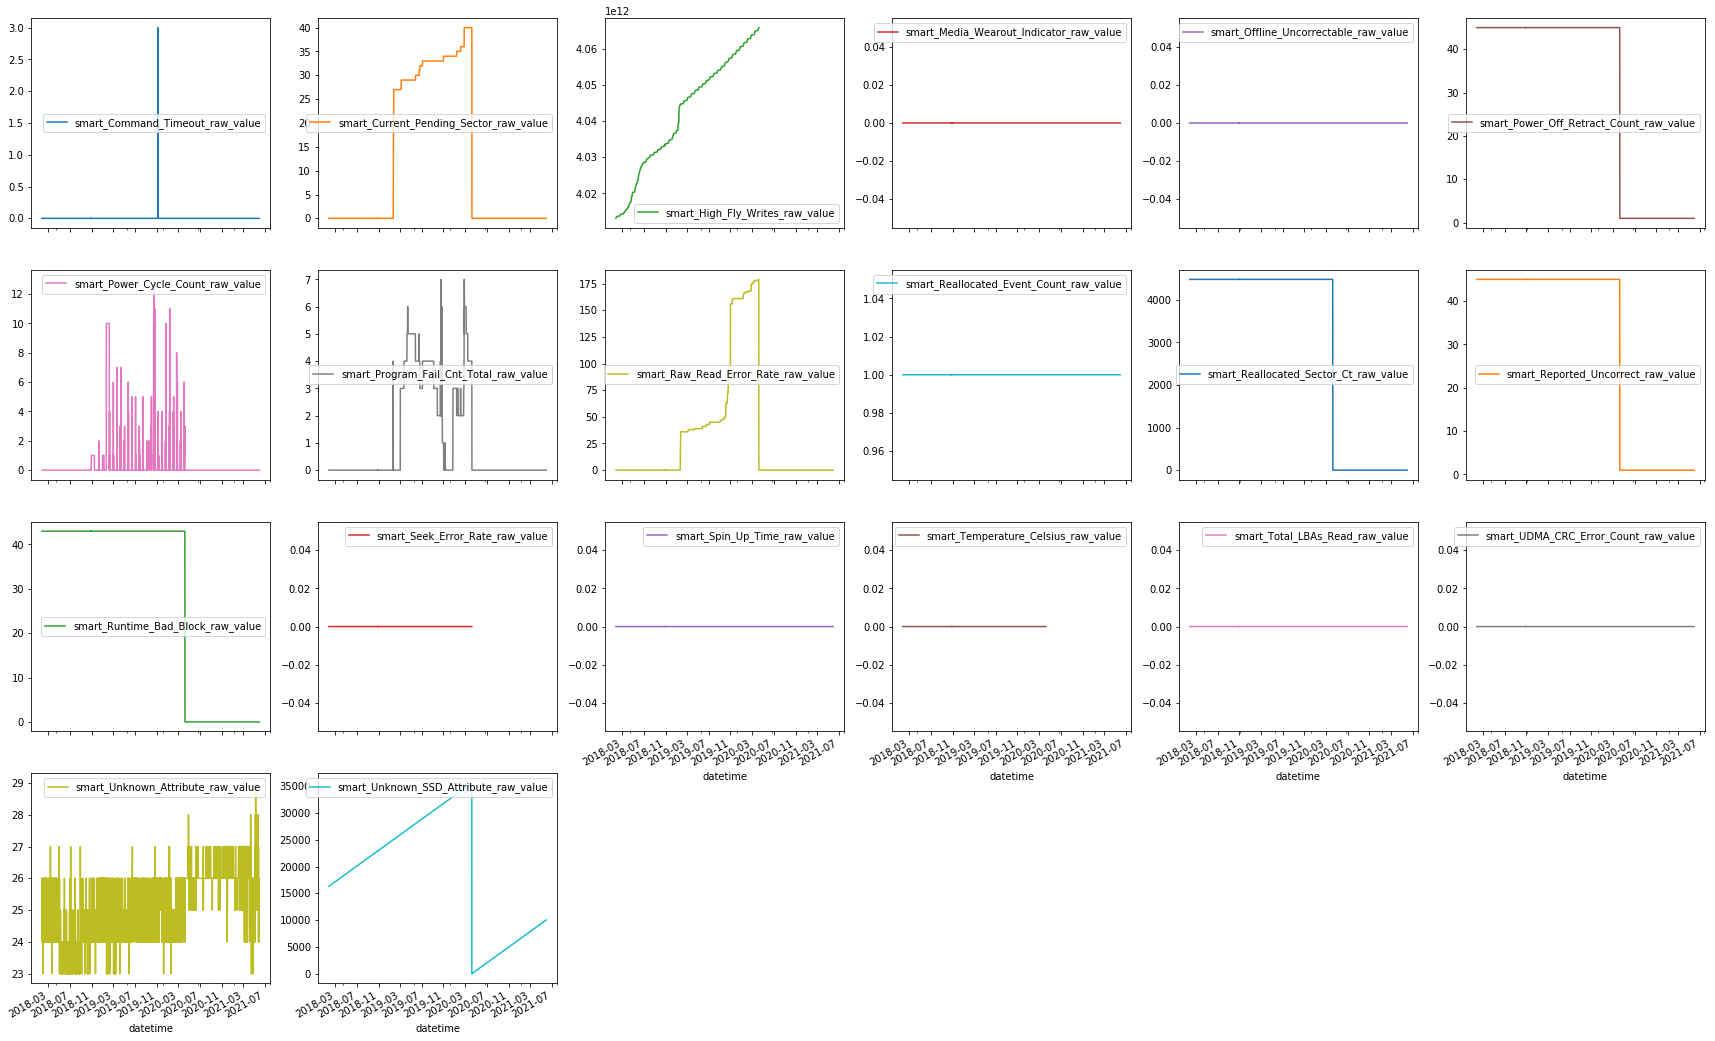

In [67]:
ppp.plot(x='datetime', y=yyy, subplots=True, layout=(6,6), figsize=(30,30))
plt.axvline(x='2020-04-07 00:00:00', color='r', linestyle='dashed')

In [ ]:
import matplotlib.pyplot as plt
rowws =[0,1,2,3,4]
colls =[0,1,2,3]

fig, axes = plt.subplots(nrows=5, ncols=4, figsize = (30,30))
fig.set_figheight(20)
fig.set_figwidth(20)
plt.rcParams['font.size'] = '8'
plt.rcParams['axes.labelsize'] = '8'

cc=0 
for i in rowws:
    for j in colls:
    
    
        ppp.plot(ax=axes[i,j], x='datetime', y=yyy[cc])
        axes[i,j].axvline(x='2020-04-02 00:00:00', color='r', linestyle='dashed')
        
        cc=cc+1
plt.savefig("plots2.pdf")

In [34]:
res.count()

3067082

In [35]:
res = res.where('type = "WDC WD2003FZEX-0"')

In [36]:
res.count()

1609317

In [37]:
(float(3067082)-float(1609317))/float(3067082)

0.47529378086402646

Ahora si vamos a ver los NaNs

In [38]:
siemprenulos = []
for i,j in zip(map(lambda x: x+' is not null',res.columns[6:35]),res.columns[6:35]) :
    cuenta = res.where(i).count()
    print j + ' : ' + str(cuenta)
    if cuenta == 0:
        siemprenulos.append(j)

smart_Command_Timeout_raw_value : 1609317
smart_Current_Pending_Sector_raw_value : 1609317
smart_End_to_End_Error_raw_value : 0
smart_G_Sense_Error_Rate_raw_value : 0
smart_Hardware_ECC_Recovered_raw_value : 0
smart_High_Fly_Writes_raw_value : 1609115
smart_Load_Cycle_Count_raw_value : 0
smart_Media_Wearout_Indicator_raw_value : 1609317
smart_Multi_Zone_Error_Rate_raw_value : 0
smart_Offline_Uncorrectable_raw_value : 1609317
smart_Power_Off_Retract_Count_raw_value : 1609317
smart_Power_Cycle_Count_raw_value : 1609317
smart_Power_On_Hours_raw_value : 0
smart_Program_Fail_Cnt_Total_raw_value : 1609317
smart_Raw_Read_Error_Rate_raw_value : 1609317
smart_Reallocated_Event_Count_raw_value : 1609317
smart_Reallocated_Sector_Ct_raw_value : 1609317
smart_Reported_Uncorrect_raw_value : 1609317
smart_Runtime_Bad_Block_raw_value : 1609317
smart_Seek_Error_Rate_raw_value : 1609115
smart_Spin_Retry_Count_raw_value : 0
smart_Spin_Up_Time_raw_value : 1609317
smart_Start_Stop_Count_raw_value : 0
smart

In [39]:
siemprenulos

['smart_End_to_End_Error_raw_value',
 'smart_G_Sense_Error_Rate_raw_value',
 'smart_Hardware_ECC_Recovered_raw_value',
 'smart_Load_Cycle_Count_raw_value',
 'smart_Multi_Zone_Error_Rate_raw_value',
 'smart_Power_On_Hours_raw_value',
 'smart_Spin_Retry_Count_raw_value',
 'smart_Start_Stop_Count_raw_value',
 'smart_Wear_Leveling_Count_raw_value']

In [40]:
res = res.drop(*siemprenulos)

In [41]:
res = res.na.drop()

In [42]:
res.count()

1609115

In [43]:
def adding_labels(real, fail, lag):
    real = datetime.strptime(str(real), "%Y-%m-%d %H:%M:%S")
    fail = datetime.strptime(str(fail), "%Y-%m-%d %H:%M:%S")
    
    #if real>=fail+timedelta(days=-7) and real<=fail:
    #if real>=fail+timedelta(days=-2) and real<=fail:
    if real>=fail+timedelta(days=-lag) and real<=fail:
        return 1 #falla
    else:
        return 0 #nofalla

In [44]:
adding_labels('2020-04-02 00:00:00', '2018-01-26 21:15:01')

0

In [45]:
adding_labels_UDF = udf(lambda x,y,z: adding_labels(x,y,z),StringType())

In [46]:
lag = 7
res = res.withColumn('label',adding_labels_UDF(res.datetime,res.timestamp_fail, lag))

In [47]:
res.createOrReplaceTempView("data2")

In [48]:
spark.sql("SELECT COUNT(*) FROM data2 WHERE LABEL=1").show()

+--------+
|count(1)|
+--------+
|    1920|
+--------+



In [49]:
spark.sql("SELECT COUNT(*) FROM data2 WHERE LABEL=0").show()

+--------+
|count(1)|
+--------+
| 1607195|
+--------+



In [50]:
float(3916)/float(1605199)

0.002439572912766579

In [51]:
spark.sql("SELECT * FROM data2 WHERE smart_Seek_Error_Rate_raw_value IS NULL").limit(1).toPandas()

,node,disk,capacity,type,timestamp_fail,datetime,smart_Command_Timeout_raw_value,smart_Current_Pending_Sector_raw_value,smart_High_Fly_Writes_raw_value,smart_Media_Wearout_Indicator_raw_value,...,smart_Reported_Uncorrect_raw_value,smart_Runtime_Bad_Block_raw_value,smart_Seek_Error_Rate_raw_value,smart_Spin_Up_Time_raw_value,smart_Temperature_Celsius_raw_value,smart_Total_LBAs_Read_raw_value,smart_UDMA_CRC_Error_Count_raw_value,smart_Unknown_Attribute_raw_value,smart_Unknown_SSD_Attribute_raw_value,label


In [52]:
spark.sql("SELECT * FROM data2 WHERE smart_Seek_Error_Rate_raw_value IS NULL").count()

0

In [53]:
res.write.parquet("etl/etldone_1.parquet", mode='overwrite')

In [3]:
df2 = spark.read.parquet('etl/etldone_1.parquet')

In [4]:
columns_important_attributes = []
columns_important_attributes.append('node')
columns_important_attributes.append('disk')
columns_important_attributes.append('type')
columns_important_attributes.append('timestamp_fail')
columns_important_attributes.extend(important_attributes)

In [5]:
df2.where('smart_Command_Timeout_raw_value !=0').select('node', 'disk',         
                                                        'type', 'timestamp_fail', 'datetime', 'smart_Command_Timeout_raw_value', 'label').limit(10).show()

+------+----+----------------+-------------------+-------------------+-------------------------------+-----+
|  node|disk|            type|     timestamp_fail|           datetime|smart_Command_Timeout_raw_value|label|
+------+----+----------------+-------------------+-------------------+-------------------------------+-----+
|c13.12| sdh|WDC WD2003FZEX-0|2020-04-07 00:00:00|2019-11-08 04:15:01|                            3.0|    0|
|c13.12| sdh|WDC WD2003FZEX-0|2020-04-07 00:00:00|2019-11-08 05:15:02|                            3.0|    0|
|c13.12| sdh|WDC WD2003FZEX-0|2020-04-07 00:00:00|2019-11-08 09:00:02|                            3.0|    0|
|c13.12| sdh|WDC WD2003FZEX-0|2020-04-07 00:00:00|2019-11-08 06:30:01|                            3.0|    0|
|c13.12| sdh|WDC WD2003FZEX-0|2020-04-07 00:00:00|2019-11-07 23:45:02|                            3.0|    0|
|c13.12| sdh|WDC WD2003FZEX-0|2020-04-07 00:00:00|2019-11-08 03:00:01|                            3.0|    0|
|c13.12| sdh|WDC WD

In [6]:
df2.createOrReplaceTempView("data3")

In [7]:
spark.sql("SELECT COUNT(*) FROM data3 where label=0").show()

+--------+
|count(1)|
+--------+
| 1607195|
+--------+



In [8]:
spark.sql("SELECT COUNT(*) FROM data3 where label=1").show()

+--------+
|count(1)|
+--------+
|    1920|
+--------+



In [9]:
siemprenulos = []
for i,j in zip(map(lambda x: x+' is not null',df2.columns[6:35]),df2.columns[6:35]) :
    cuenta = df2.where(i).count()
    print j + ' : ' + str(cuenta)
    if cuenta == 0:
        siemprenulos.append(j)

smart_Command_Timeout_raw_value : 1609115
smart_Current_Pending_Sector_raw_value : 1609115
smart_High_Fly_Writes_raw_value : 1609115
smart_Media_Wearout_Indicator_raw_value : 1609115
smart_Offline_Uncorrectable_raw_value : 1609115
smart_Power_Off_Retract_Count_raw_value : 1609115
smart_Power_Cycle_Count_raw_value : 1609115
smart_Program_Fail_Cnt_Total_raw_value : 1609115
smart_Raw_Read_Error_Rate_raw_value : 1609115
smart_Reallocated_Event_Count_raw_value : 1609115
smart_Reallocated_Sector_Ct_raw_value : 1609115
smart_Reported_Uncorrect_raw_value : 1609115
smart_Runtime_Bad_Block_raw_value : 1609115
smart_Seek_Error_Rate_raw_value : 1609115
smart_Spin_Up_Time_raw_value : 1609115
smart_Temperature_Celsius_raw_value : 1609115
smart_Total_LBAs_Read_raw_value : 1609115
smart_UDMA_CRC_Error_Count_raw_value : 1609115
smart_Unknown_Attribute_raw_value : 1609115
smart_Unknown_SSD_Attribute_raw_value : 1609115
label : 1609115


In [10]:
df2.count()

1609115

In [11]:
df2.limit(10).toPandas()

,node,disk,capacity,type,timestamp_fail,datetime,smart_Command_Timeout_raw_value,smart_Current_Pending_Sector_raw_value,smart_High_Fly_Writes_raw_value,smart_Media_Wearout_Indicator_raw_value,...,smart_Reported_Uncorrect_raw_value,smart_Runtime_Bad_Block_raw_value,smart_Seek_Error_Rate_raw_value,smart_Spin_Up_Time_raw_value,smart_Temperature_Celsius_raw_value,smart_Total_LBAs_Read_raw_value,smart_UDMA_CRC_Error_Count_raw_value,smart_Unknown_Attribute_raw_value,smart_Unknown_SSD_Attribute_raw_value,label
0,c13.1,sdb,1.8T,WDC WD2003FZEX-0,2020-04-02 00:00:00,2018-01-27 04:15:01,0.0,1.0,8.122593e+11,0.0,...,49.0,46.0,0.0,11.0,0.0,0.0,0.0,24.0,13258.0,0
1,c13.1,sdb,1.8T,WDC WD2003FZEX-0,2020-04-02 00:00:00,2018-01-28 15:45:01,0.0,1.0,8.122709e+11,0.0,...,49.0,46.0,0.0,11.0,0.0,0.0,0.0,24.0,13293.0,0
2,c13.1,sdb,1.8T,WDC WD2003FZEX-0,2020-04-02 00:00:00,2018-01-31 18:00:01,0.0,1.0,8.122896e+11,0.0,...,49.0,46.0,0.0,11.0,0.0,0.0,0.0,24.0,13367.0,0
3,c13.1,sdb,1.8T,WDC WD2003FZEX-0,2020-04-02 00:00:00,2018-02-06 05:00:02,0.0,1.0,8.123246e+11,0.0,...,49.0,46.0,0.0,11.0,0.0,0.0,0.0,24.0,13498.0,0
4,c13.1,sdb,1.8T,WDC WD2003FZEX-0,2020-04-02 00:00:00,2018-02-08 15:45:01,0.0,1.0,8.123401e+11,0.0,...,49.0,46.0,0.0,11.0,0.0,0.0,0.0,24.0,13557.0,0
5,c13.1,sdb,1.8T,WDC WD2003FZEX-0,2020-04-02 00:00:00,2018-02-09 09:15:01,0.0,1.0,8.123402e+11,0.0,...,49.0,46.0,0.0,11.0,0.0,0.0,0.0,25.0,13574.0,0
6,c13.1,sdb,1.8T,WDC WD2003FZEX-0,2020-04-02 00:00:00,2018-02-09 18:00:01,0.0,1.0,8.123402e+11,0.0,...,49.0,46.0,0.0,11.0,0.0,0.0,0.0,24.0,13583.0,0
7,c13.1,sdb,1.8T,WDC WD2003FZEX-0,2020-04-02 00:00:00,2018-02-16 06:15:01,0.0,1.0,8.123706e+11,0.0,...,49.0,46.0,0.0,11.0,0.0,0.0,0.0,25.0,13739.0,0
8,c13.1,sdb,1.8T,WDC WD2003FZEX-0,2020-04-02 00:00:00,2018-02-19 16:30:02,0.0,1.0,8.123874e+11,0.0,...,49.0,46.0,0.0,11.0,0.0,0.0,0.0,24.0,13821.0,0
9,c13.1,sdb,1.8T,WDC WD2003FZEX-0,2020-04-02 00:00:00,2018-02-22 12:00:01,0.0,1.0,8.124029e+11,0.0,...,49.0,46.0,0.0,11.0,0.0,0.0,0.0,25.0,13889.0,0


In [12]:
important_attributes

['smart_Reallocated_Sector_Ct_raw_value',
 'smart_Power_Cycle_Count_raw_value',
 'smart_Reported_Uncorrect_raw_value',
 'smart_Command_Timeout_raw_value',
 'smart_High_Fly_Writes_raw_value',
 'smart_Offline_Uncorrectable_raw_value',
 'smart_UDMA_CRC_Error_Count_raw_value',
 'label']

In [4]:
from pyspark.ml.linalg import DenseVector

 
#input_data = df2.select(df2.columns[6:])
input_data = df2.select(important_attributes)
#input_data = input_data.rdd.map(lambda x: (x[8], DenseVector(x[:8])))
input_data = input_data.rdd.map(lambda x: (x[7], DenseVector(x[:7])))


output = spark.createDataFrame(input_data, ["label", "features"])

In [5]:
output.createOrReplaceTempView("data4")

In [6]:
spark.sql("select distinct label from data4").show()

+-----+
|label|
+-----+
|    0|
|    1|
+-----+



In [7]:
output.printSchema()

root
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)



In [8]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scalerModel = scaler.fit(output)
scaledData = scalerModel.transform(output).select('label', 'scaledFeatures')

In [9]:
scaledData.limit(5).show()

+-----+--------------------+
|label|      scaledFeatures|
+-----+--------------------+
|    0|[-0.9267429654778...|
|    0|[-0.9267429654778...|
|    0|[-0.9267429654778...|
|    0|[-0.9267429654778...|
|    0|[-0.9267429654778...|
+-----+--------------------+



In [10]:
scaledData = scaledData.withColumnRenamed('scaledFeatures', 'features')

In [11]:
scaledData = scaledData.select( "features", scaledData.label.cast(LongType()))

In [12]:
scaledData.limit(5).show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.9267429654778...|    0|
|[-0.9267429654778...|    0|
|[-0.9267429654778...|    0|
|[-0.9267429654778...|    0|
|[-0.9267429654778...|    0|
+--------------------+-----+



Recuerda que hay que hacer SMOTE antes de PCA.

In [55]:
import random
import numpy as np
from pyspark.sql import Row
from sklearn import neighbors
from pyspark.ml.feature import VectorAssembler

def vectorizerFunction(dataInput, TargetFieldName):
    if(dataInput.select(TargetFieldName).distinct().count() != 2):
        raise ValueError("Target field must have only 2 distinct classes")
    columnNames = list(dataInput.columns)
    columnNames.remove(TargetFieldName)
    dataInput = dataInput.select((','.join(columnNames)+','+TargetFieldName).split(','))
    assembler=VectorAssembler(inputCols = columnNames, outputCol = 'features')
    pos_vectorized = assembler.transform(dataInput)
    vectorized = pos_vectorized.select('features',TargetFieldName).withColumn('label',pos_vectorized[TargetFieldName]).drop(TargetFieldName)
    return vectorized

def SmoteSampling(vectorized, k = 5, minorityClass = 1, majorityClass = 0, percentageOver = 200, percentageUnder = 100):
    if(percentageUnder > 100|percentageUnder < 10):
        raise ValueError("Percentage Under must be in range 10 - 100");
    if(percentageOver < 100):
        raise ValueError("Percentage Over must be in at least 100");
    dataInput_min = vectorized[vectorized['label'] == minorityClass]
    dataInput_maj = vectorized[vectorized['label'] == majorityClass]
    feature = dataInput_min.select('features')
    feature = feature.rdd
    feature = feature.map(lambda x: x[0])
    feature = feature.collect()
    feature = np.asarray(feature)
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm='auto').fit(feature)
    neighbours =  nbrs.kneighbors(feature)
    gap = neighbours[0]
    neighbours = neighbours[1]
    min_rdd = dataInput_min.drop('label').rdd
    pos_rddArray = min_rdd.map(lambda x : list(x))
    pos_ListArray = pos_rddArray.collect()
    min_Array = list(pos_ListArray)
    newRows = []
    nt = len(min_Array)
    nexs = percentageOver/100
    for i in range(nt):
        for j in range(nexs):
            neigh = random.randint(1,k)
            difs = min_Array[neigh][0] - min_Array[i][0]
            newRec = (min_Array[i][0]+random.random()*difs)
            newRows.insert(0,(newRec))
    newData_rdd = sc.parallelize(newRows)
    newData_rdd_new = newData_rdd.map(lambda x: Row(features = x, label = 1))
    new_data = newData_rdd_new.toDF()
    new_data_minor = dataInput_min.unionAll(new_data)
    new_data_major = dataInput_maj.sample(False, (float(percentageUnder)/float(100)))
    return new_data_major.unionAll(new_data_minor)


In [13]:
scaledData.count()

1609115

In [14]:
train, test = scaledData.randomSplit([0.6,0.4], seed = 2)

In [15]:
#UNDERSAMPLING solo al train
failDf = train.filter(train.label==1)
nofailDf = train.filter(train.label==0)
sampleRatio = float(failDf.count()) / float(train.count())
nofailDfSampleDf = nofailDf.sample(False, sampleRatio, seed=123)

In [16]:
nofailDfSampleDf.count()

1079

In [17]:
failDf.count()

1127

In [18]:
train.count()

965462

In [19]:
test.count()

643653

In [30]:
test.where('label="1"').count()

793

In [20]:
train = failDf.unionAll(nofailDfSampleDf)

In [21]:
train.count()

2206

In [104]:
float(1594700)/float(14415)

110.6278182448838

In [57]:
#dimequesi = SmoteSampling(scaledData, k = 2, minorityClass = 1, majorityClass = 0, percentageOver = 1110, percentageUnder = 11)

In [34]:
#dimequesi.printSchema()

In [78]:
#dimequesi.createOrReplaceTempView("data55")

In [33]:
#spark.sql("SELECT COUNT(*) FROM data55 where label=0").show()

In [35]:
#spark.sql("SELECT COUNT(*) FROM data55 where label=1").show()

In [36]:
#dimequesi.limit(1).show()

In [22]:
train = train.select(train.features, train.label.cast('double'))

In [83]:
#train, test = dimequesi.randomSplit([0.7,0.3], seed = 2)

In [23]:
train.createOrReplaceTempView("data55")

In [24]:
spark.sql("SELECT COUNT(*) as L0 FROM data55 where label=0").show()

+----+
|  L0|
+----+
|1079|
+----+



In [25]:
spark.sql("SELECT COUNT(*) as L1 FROM data55 where label=1").show()

+----+
|  L1|
+----+
|1127|
+----+



In [26]:
test.createOrReplaceTempView("data56")

In [27]:
spark.sql("SELECT COUNT(*) as L0 FROM data56 where label=0").show() 

+------+
|    L0|
+------+
|642860|
+------+



In [28]:
spark.sql("SELECT COUNT(*) as L1 FROM data56 where label=1").show()

+---+
| L1|
+---+
|793|
+---+



In [29]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(train)
train_pca = model.transform(train).select("pcaFeatures", 'label')
train_pca = train_pca.withColumnRenamed("pcaFeatures", 'features')
train_pca.limit(10).show(truncate=False)

+--------------------------------------------------------------+-----+
|features                                                      |label|
+--------------------------------------------------------------+-----+
|[0.0112233009476904,-0.875474210620337,-1.6385625777418802]   |1.0  |
|[0.011223425438569946,-0.875474963331365,-1.6385547518011354] |1.0  |
|[0.011223440067383569,-0.8754750517817751,-1.6385538321817303]|1.0  |
|[0.011223454696197187,-0.8754751402321852,-1.6385529125623257]|1.0  |
|[0.011223462026822197,-0.8754751845554505,-1.6385524517330894]|1.0  |
|[0.011223476655635816,-0.8754752730058604,-1.6385515321136845]|1.0  |
|[0.011223543052934003,-0.8754756744648169,-1.6385473581426828]|1.0  |
|[0.01122360160062488,-0.8754760284625775,-1.6385436776259958] |1.0  |
|[0.011223785709596298,-0.8754771416433476,-1.6385321038793392]|1.0  |
|[0.011223800370846315,-0.8754772302898781,-1.638531182220867] |1.0  |
+--------------------------------------------------------------+-----+



In [30]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(test)
test_pca = model.transform(test).select("pcaFeatures",'label')
test_pca = test_pca.withColumnRenamed("pcaFeatures", 'features')
test_pca.limit(10).show(truncate=False)

+------------------------------------------------------------+-----+
|features                                                    |label|
+------------------------------------------------------------+-----+
|[2.3799208036397843,0.09425001119198623,0.41404799366118905]|0    |
|[2.379920803186887,0.09425001015863882,0.4140479934844577]  |0    |
|[2.379920803186887,0.09425001015863882,0.4140479934844577]  |0    |
|[2.379920803186887,0.09425001015863882,0.4140479934844577]  |0    |
|[2.3799207812213763,0.09424996004128866,0.41404798491298717]|0    |
|[2.379920779183339,0.09424995539122522,0.4140479841176961]  |0    |
|[2.3799207757866108,0.09424994764111955,0.414047982792211]  |0    |
|[2.3799207721634335,0.09424993937434017,0.4140479813783602] |0    |
|[2.379920768993154,0.09424993214090821,0.4140479801412407]  |0    |
|[2.3799207669551166,0.09424992749084476,0.41404797934594967]|0    |
+------------------------------------------------------------+-----+



In [31]:
print train_pca.count()
print test_pca.count()

2206
643653


In [32]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, featuresCol='features', labelCol='label')

# Fit the model
lrModel = lr.fit(train_pca)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [0.0,0.0,0.0]
Intercept: 0.0435245487816


In [33]:
predictions_train = lrModel.transform(train_pca)

In [34]:
predictions_test = lrModel.transform(test_pca)

In [35]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print 'Test Area Under ROC ' + str(evaluator.evaluate(predictions_test))

Test Area Under ROC 0.5


In [36]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print 'Test Area Under ROC ' + str(evaluator.evaluate(predictions_train))

Test Area Under ROC 0.5


In [37]:
print 'Accuracy ' + str(predictions_test.filter(predictions_test.label == predictions_test.prediction).count()/float(predictions_test.count()))

Accuracy 0.00123203030204


In [38]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder().addGrid(lr.regParam, [0.01,0.5,1.0,2.0])
             .addGrid(lr.elasticNetParam, [0.0,0.5,1.0])
             .addGrid(lr.maxIter, [1,3,5,8,10])
             .addGrid(lr.threshold, [0.5,0.6,0.7])
             .build())

In [39]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [40]:
cvModel = cv.fit(train_pca)

In [41]:
predictions_test_2 = cvModel.transform(test_pca)
print 'Test Area Under ROC ' + str(evaluator.evaluate(predictions_test_2))

Test Area Under ROC 0.637373524382


In [42]:
predictions_train_2 = cvModel.transform(train_pca)
print 'Test Area Under ROC ' + str(evaluator.evaluate(predictions_train_2))

Test Area Under ROC 0.702034402027


In [43]:
best_model = cvModel.bestModel

In [44]:
best_model._java_obj.getRegParam()
best_model._java_obj.getMaxIter()
best_model._java_obj.getElasticNetParam()


0.0

Prediccion     0.0     1.0
Actual                    
0           521177  121683
1              511     282


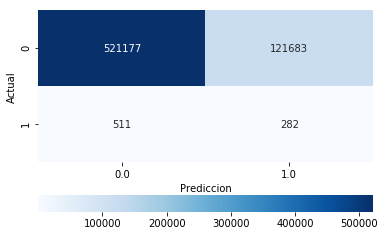

In [49]:
ccm_lg = predictions_test_2.select('label', 'prediction').toPandas()
confusion_matrix = pd.crosstab(ccm_lg['label'], ccm_lg['prediction'], rownames=['Actual'], colnames=['Prediccion'])
print (confusion_matrix)
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt='g', cbar_kws={"orientation": "horizontal"})
plt.savefig('CM_LG_UNDER_1.pdf')


In [46]:
from sklearn.metrics import classification_report
report = classification_report(ccm_lg['label'], ccm_lg['prediction'], output_dict=True)

In [47]:
pd.DataFrame(report).transpose()

,f1-score,precision,recall,support
0,0.895072,0.999020,0.810716,642860.0
1,0.004594,0.002312,0.355612,793.0
macro avg,0.449833,0.500666,0.583164,643653.0
micro avg,0.810155,0.810155,0.810155,643653.0
weighted avg,0.893975,0.997793,0.810155,643653.0


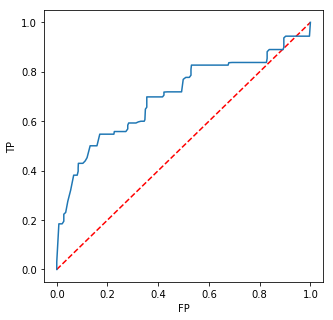

In [50]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(best_model.summary.roc.select('FPR').collect(),
         best_model.summary.roc.select('TPR').collect())
plt.xlabel('FP')
plt.ylabel('TP')
plt.savefig('ROC_LG_UNDER_1.pdf')

# SVM

In [51]:
from pyspark.ml.classification import LinearSVC, LinearSVCModel

In [52]:
# Define your classifier
lsvc = LinearSVC(maxIter=10, regParam=0.1)

In [53]:
lsvcModel = lsvc.fit(train_pca)

In [54]:
coefficients = lsvcModel.coefficients
intercept = lsvcModel.intercept
print("Some coefficients: " + str(coefficients[250:300]))
print("Intercept: " + str(intercept))

Some coefficients: []
Intercept: -0.68077763477


In [55]:
predictions_train_SVM = lsvcModel.transform(train_pca)

In [56]:
predictions_test_SVM = lsvcModel.transform(test_pca)

In [57]:
evaluator = BinaryClassificationEvaluator()
print 'Test Area Under ROC ' + str(evaluator.evaluate(predictions_test_SVM))

Test Area Under ROC 0.678912053791


In [58]:
evaluator = BinaryClassificationEvaluator()
print 'Test Area Under ROC ' + str(evaluator.evaluate(predictions_train_SVM))

Test Area Under ROC 0.675777713269


In [59]:
print 'Accuracy ' + str(predictions_test_SVM.filter(predictions_test_SVM.label == predictions_test_SVM.prediction).count()/float(predictions_test_SVM.count()))

Accuracy 0.975295695041


In [60]:
paramGrid = (ParamGridBuilder().addGrid(lsvc.regParam, [10, 1, 0.1, 0.01, 0.001, 0.0001])
                                       .addGrid(lr.maxIter, [1,5,10])
             .build())

In [61]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
cv = TrainValidationSplit(estimator=lsvc, estimatorParamMaps=paramGrid,trainRatio=0.8, 
                          evaluator=MulticlassClassificationEvaluator(metricName = 'truePositiveRateByLabel'))

In [62]:
#cv = CrossValidator(estimator=lsvc, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

In [63]:
cvModel = cv.fit(train_pca)

In [64]:
predictions_test_2_SVM = cvModel.transform(test_pca)
print 'Test Area Under ROC ' + str(evaluator.evaluate(predictions_test_2_SVM))

Test Area Under ROC 0.481776654483


In [65]:
predictions_train_2_SVM = cvModel.transform(train_pca)
print 'Test Area Under ROC ' + str(evaluator.evaluate(predictions_train_2_SVM))

Test Area Under ROC 0.694075736431


In [66]:
print 'Accuracy ' + str(predictions_test_2_SVM.filter(predictions_test_2_SVM.label == predictions_test_2_SVM.prediction).count()/float(predictions_test_2_SVM.count()))

Accuracy 0.932401464764


In [67]:
best_model_SVM = cvModel.bestModel

In [68]:
best_model_SVM._java_obj.getRegParam()
best_model_SVM._java_obj.getMaxIter()

10

Prediccion     0.0    1.0
Actual                   
0           600026  42834
1              676    117


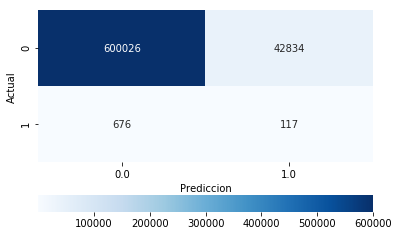

In [74]:
ccm_svm = predictions_test_2_SVM.select('label', 'prediction').toPandas()
confusion_matrix = pd.crosstab(ccm_svm['label'], ccm_svm['prediction'], rownames=['Actual'], colnames=['Prediccion'])
print (confusion_matrix)
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt='g', cbar_kws={"orientation": "horizontal"})
plt.savefig('images/CM_SVM_UNDER_1.pdf')


In [71]:
report = classification_report(ccm_svm['label'], ccm_svm['prediction'], output_dict=True)

In [72]:
pd.DataFrame(report).transpose()

,f1-score,precision,recall,support
0,0.965012,0.998875,0.933370,642860.0
1,0.005349,0.002724,0.147541,793.0
macro avg,0.485181,0.500799,0.540455,643653.0
micro avg,0.932401,0.932401,0.932401,643653.0
weighted avg,0.963829,0.997647,0.932401,643653.0


AttributeError: 'LinearSVCModel' object has no attribute 'summary'

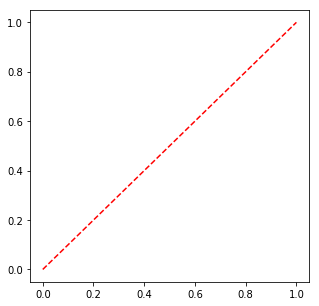

In [73]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(best_model_SVM.summary.roc.select('FPR').collect(),
         best_model_SVM.summary.roc.select('TPR').collect())
plt.xlabel('FP')
plt.ylabel('TP')
#plt.savefig('images/ROC_SVM_UNDER_1.pdf')

# RANDOM FOREST

In [75]:
from pyspark.ml.classification import RandomForestClassifier

In [76]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_pca)

In [77]:
predictions_train_RF = rfModel.transform(train_pca)

In [78]:
predictions_test_RF = rfModel.transform(test_pca)

In [79]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print 'Test Area Under ROC ' + str(evaluator.evaluate(predictions_test_RF))

Test Area Under ROC 0.519912814539


In [80]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print 'Test Area Under ROC ' + str(evaluator.evaluate(predictions_train_RF))

Test Area Under ROC 0.944216152029


In [81]:
print 'Accuracy ' + str(predictions_test_RF.filter(predictions_test_RF.label == predictions_test_RF.prediction).count()/float(predictions_test_RF.count()))

Accuracy 0.429813890404


In [82]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder().addGrid(rf.maxDepth, [1,2,3,4,5])
             .addGrid(rf.minInstancesPerNode, [1,5,10])
             .build())

In [94]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
cv = TrainValidationSplit(estimator=rf, estimatorParamMaps=paramGrid,trainRatio=0.8, 
                          evaluator=MulticlassClassificationEvaluator())

In [95]:
cvModel = cv.fit(train_pca)

In [96]:
predictions_test_2 = cvModel.transform(test_pca)
print 'Test Area Under ROC ' + str(evaluator.evaluate(predictions_test_2))

Test Area Under ROC 0.519912814539


In [97]:
predictions_train_2 = cvModel.transform(train_pca)
print 'Test Area Under ROC ' + str(evaluator.evaluate(predictions_train_2))

Test Area Under ROC 0.944216152029


In [98]:
best_model = cvModel.bestModel

Prediccion     0.0     1.0
Actual                    
0           276193  366667
1              335     458


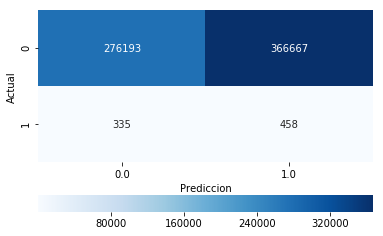

In [99]:
ccm_lg = predictions_test_2.select('label', 'prediction').toPandas()
confusion_matrix = pd.crosstab(ccm_lg['label'], ccm_lg['prediction'], rownames=['Actual'], colnames=['Prediccion'])
print (confusion_matrix)
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt='g', cbar_kws={"orientation": "horizontal"})
plt.savefig('CM_RF_UNDER.pdf')


In [100]:
from sklearn.metrics import classification_report
report = classification_report(ccm_lg['label'], ccm_lg['prediction'], output_dict=True)

In [101]:
pd.DataFrame(report).transpose()

,f1-score,precision,recall,support
0,0.600819,0.998789,0.429632,642860.0
1,0.002490,0.001248,0.577554,793.0
macro avg,0.301654,0.500018,0.503593,643653.0
micro avg,0.429814,0.429814,0.429814,643653.0
weighted avg,0.600082,0.997560,0.429814,643653.0


AttributeError: 'RandomForestClassificationModel' object has no attribute 'summary'

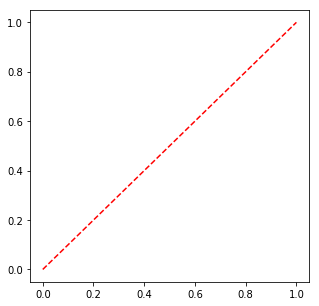

In [102]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(best_model.summary.roc.select('FPR').collect(),
         best_model.summary.roc.select('TPR').collect())
plt.xlabel('FP')
plt.ylabel('TP')
plt.savefig('ROC_RF_UNDER.pdf')